In [1]:
import pandas as pd
import numpy as np
from importlib import reload
from tqdm import tqdm_notebook as tqdm
import time
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm, chi2
from scipy import stats
import matplotlib.pyplot as plt

import pdaactconn as pc
from trialexplorer import AACTStudySet
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/Users/akhazan/.virtualenvs/notebooks_venv/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
conn = pc.AACTConnection(source=pc.AACTConnection.REMOTE)
ss = AACTStudySet.AACTStudySet(conn=conn, tqdm_handler=tqdm)
ss.add_constraint("study_type = 'Interventional'")
ss.add_constraint("results_first_submitted_date is not null")
ss.add_constraint("enrollment_type = 'Actual'")
ss.add_constraint("enrollment >= 10")
ss.add_constraint("enrollment <= 500")
ss.add_constraint("phase = 'Phase 2'")
ss.load_studies()

8780 studies loaded!


In [3]:
ss.add_dimensions(['baseline_measurements', 'result_groups', 'outcomes', 'outcome_measurements', 'outcome_counts', 'outcome_analyses'])
ss.refresh_dim_data()
rg = ss.dimensions['result_groups']
bm = ss.dimensions['baseline_measurements']
om = ss.dimensions['outcome_measurements']
oa = ss.dimensions['outcome_analyses']
oc = ss.dimensions['outcome_counts']
out = ss.dimensions['outcomes']

Successfuly added these 6 dimensions: ['baseline_measurements', 'result_groups', 'outcomes', 'outcome_measurements', 'outcome_counts', 'outcome_analyses']
Failed to add these 0 dimensions: []


Syncing the temp table temp_cur_studies in 18 chunks x 500 records each

Creating index on the temp table
 - Loading dimension baseline_measurements
 -- Loading raw data
 -- Sorting index
 - Loading dimension result_groups
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcomes
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcome_measurements
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcome_counts
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcome_analyses
 -- Loading raw data
 -- Sorting index


In [4]:
#Get studies with exactly two treatment groups besides "Total" and grab necessary columns
combined_measures = pd.merge(rg.data, bm.data, left_on = ['nct_id', 'id'], right_on = ['nct_id', 'result_group_id'])
combined_measures = combined_measures[combined_measures.title_x != 'Total']
num_groups = combined_measures.groupby('nct_id').ctgov_group_code_x.nunique()
num_groups = pd.DataFrame(num_groups)
num_groups.columns.values[0] = 'n_groups'
combined_measures = combined_measures.merge(num_groups, on=['nct_id'])
combined_measures = combined_measures[combined_measures.n_groups==2]
study_balance_dat = combined_measures[['ctgov_group_code_x', 'classification', 'category', 'title_y',
                                       'param_type', 'param_value_num',
                                       'dispersion_type', 'dispersion_value_num']]

In [5]:
study_balance_dat.title_y.value_counts().head(10)
#We'll go with age and sex for now

Sex: Female, Male                                               11814
Age                                                             11745
Race (NIH/OMB)                                                  11039
Region of Enrollment                                             5024
Race/Ethnicity, Customized                                       3724
Ethnicity (NIH/OMB)                                              3489
Age, Customized                                                  1514
Gender                                                            408
Eastern Cooperative Oncology Group (ECOG) Performance Status      240
Weight                                                            152
Name: title_y, dtype: int64

In [6]:
sb_age = study_balance_dat[study_balance_dat.title_y == 'Age']
sb_age_cat = sb_age[sb_age.param_type=='Count of Participants']
sb_age_con = sb_age[sb_age.param_type=='Mean']
print(sb_age_cat.index.nunique())
print(sb_age_con.index.nunique())
#We'll choose the continuous version for now, since it has more

1053
2211


In [7]:
#Sex is always a count variable; only variability is capitalization of "category" field
#Get rid of rows that aren't sex or age
age_condition1 = study_balance_dat.title_y == 'Age'
age_condition2 = study_balance_dat.param_type == 'Mean'
sex_condition = study_balance_dat.title_y == 'Sex: Female, Male'
full_condition = (age_condition1 & age_condition2) | sex_condition
small_balance_dat = study_balance_dat[full_condition]
small_balance_dat.head(20)

,ctgov_group_code_x,classification,category,title_y,param_type,param_value_num,dispersion_type,dispersion_value_num
nct_id,,,,,,,,
NCT00000392,B2,,Male,"Sex: Female, Male",Count of Participants,104.00,,NaN
NCT00000392,B2,,Female,"Sex: Female, Male",Count of Participants,5.00,,NaN
NCT00000392,B1,,Male,"Sex: Female, Male",Count of Participants,101.00,,NaN
NCT00000392,B1,,Female,"Sex: Female, Male",Count of Participants,5.00,,NaN
NCT00001304,B2,,Male,"Sex: Female, Male",Count of Participants,4.00,,NaN
NCT00001304,B2,,Female,"Sex: Female, Male",Count of Participants,10.00,,NaN
NCT00001304,B1,,Male,"Sex: Female, Male",Count of Participants,6.00,,NaN
NCT00001304,B1,,Female,"Sex: Female, Male",Count of Participants,7.00,,NaN
NCT00001586,B2,,Male,"Sex: Female, Male",Count of Participants,35.00,,NaN


In [8]:
#get studies that have both measures we're using
num_measures = small_balance_dat.groupby('nct_id').title_y.nunique()
num_measures = pd.DataFrame(num_measures)
num_measures.columns.values[0] = 'n_measures'
small_balance_dat = small_balance_dat.merge(num_measures, on=['nct_id'])
small_balance_dat = small_balance_dat[small_balance_dat.n_measures==2]

#assert that each study has 6 rows now--2 sex and 1 age for each of the 2 arms
num_rows = small_balance_dat.groupby('nct_id').title_y.count()
num_rows = pd.DataFrame(num_rows)
num_rows.columns.values[0] = 'n_rows'
small_balance_dat = small_balance_dat.merge(num_rows, on=['nct_id'])
small_balance_dat = small_balance_dat[small_balance_dat.n_rows == 6]

In [9]:
#handle aforementioned capitalization issue
small_balance_dat.category = small_balance_dat.category.str.lower()
small_balance_dat.head()

,ctgov_group_code_x,classification,category,title_y,param_type,param_value_num,dispersion_type,dispersion_value_num,n_measures,n_rows
nct_id,,,,,,,,,,
NCT00001586,B2,,male,"Sex: Female, Male",Count of Participants,35.00,,NaN,2,6
NCT00001586,B2,,female,"Sex: Female, Male",Count of Participants,21.00,,NaN,2,6
NCT00001586,B2,,,Age,Mean,58.42,Standard Deviation,11.32,2,6
NCT00001586,B1,,male,"Sex: Female, Male",Count of Participants,30.00,,NaN,2,6
NCT00001586,B1,,female,"Sex: Female, Male",Count of Participants,19.00,,NaN,2,6


In [10]:
def calculate_imbalance(study_frame):
    nctid = study_frame.index[0]
    group_codes = study_frame.ctgov_group_code_x.unique()
    group1 = study_frame[study_frame.ctgov_group_code_x == group_codes[0]]
    group2 = study_frame[study_frame.ctgov_group_code_x == group_codes[1]]
    
    sex_imbalance, group_size_imbalance = calculate_sex_imbalance(group1, group2)
    age_imbalance = calculate_age_imbalance(group1, group2)
    
    return([nctid, sex_imbalance, age_imbalance, group_size_imbalance])

def calculate_sex_imbalance(arm1, arm2):
    arm1_sex = arm1[arm1.title_y == 'Sex: Female, Male']
    arm2_sex = arm2[arm2.title_y == 'Sex: Female, Male']
    
    arm1_size = arm1_sex.param_value_num.sum()
    arm2_size = arm2_sex.param_value_num.sum()
    
    arm1_men = arm1_sex[arm1_sex.category == 'male'].param_value_num[0]
    arm2_men = arm2_sex[arm2_sex.category == 'male'].param_value_num[0]
    
    arm1_pct_men = arm1_men / arm1_size
    arm2_pct_men = arm2_men / arm2_size
    
    sex_imbalance = abs(arm1_pct_men - arm2_pct_men)
    group_size_imbalance = abs(0.5 - (arm1_size) / (arm1_size + arm2_size))
    return((sex_imbalance, group_size_imbalance))

def calculate_age_imbalance(arm1, arm2):
    arm1_mean_age = arm1[arm1.title_y == 'Age'].param_value_num[0]
    arm2_mean_age = arm2[arm2.title_y == 'Age'].param_value_num[0]
    
    age_imbalance = 12 * abs(arm1_mean_age - arm2_mean_age) 
    return(age_imbalance)

In [11]:
#Time to calculate imbalances
imbalance_dat = []
study_ids = small_balance_dat.index.unique()
n_studies = study_ids.shape[0]
print('Calculating imbalance for ' + str(n_studies) + ' studies')
for i in range(n_studies):
    current_id = study_ids[i]
    current_study = small_balance_dat[small_balance_dat.index == current_id]
    current_imbalances = calculate_imbalance(current_study)
    imbalance_dat.append(current_imbalances)
    if (i + 1) % 1000 == 0:
        print('Finished with ' + str(i + 1) + ' studies.')
imbalance_frame = pd.DataFrame(imbalance_dat, columns = ['nct_id', 'sex_imbalance', 'age_imbalance', 'group_size_imbalance'])
imbalance_frame.head()

Calculating imbalance for 2105 studies
Finished with 1000 studies.
Finished with 2000 studies.


,nct_id,sex_imbalance,age_imbalance,group_size_imbalance
0,NCT00001586,0.012755,26.64,0.033333
1,NCT00001596,0.152174,53.28,0.157143
2,NCT00001723,0.010000,1.56,0.000000
3,NCT00003222,0.217033,24.00,0.182927
4,NCT00004980,0.014493,4.80,0.040000


In [12]:
om.data.reset_index(inplace=True)
out.data.reset_index(inplace=True)
rg.data.reset_index(inplace=True)
oa.data.reset_index(inplace=True)
oc.data.reset_index(inplace=True)
out.data = out.data.add_prefix('out_')
om.data = om.data.add_prefix('om_')
rg.data = rg.data.add_prefix('rg_')
oa.data = oa.data.add_prefix('oa_')
oc.data = oc.data.add_prefix('oc_')

In [13]:
combined_outcomes = om.data.merge(out.data, left_on = ['om_nct_id', 'om_outcome_id'], 
                                  right_on = ['out_nct_id', 'out_id'])

combined_outcomes = combined_outcomes.merge(rg.data, left_on = ['om_nct_id','om_result_group_id'], 
                                            right_on = ['rg_nct_id','rg_id'])
primary_outcomes = combined_outcomes[combined_outcomes.out_outcome_type == 'Primary']

In [14]:
num_groups = primary_outcomes.groupby(['om_nct_id', 'om_outcome_id']).om_result_group_id.nunique()
num_groups = pd.DataFrame(num_groups)
num_groups.columns.values[0] = 'n_groups'
primary_outcomes = primary_outcomes.merge(num_groups, on=['om_nct_id', 'om_outcome_id'])
primary_outcomes = primary_outcomes[primary_outcomes.n_groups==2]

In [15]:
primary_outcomes = primary_outcomes.merge(
    oc.data.drop_duplicates(subset=['oc_nct_id', 'oc_result_group_id', 'oc_outcome_id'], keep='first'), 
    left_on=['om_nct_id', 'om_result_group_id', 'om_outcome_id'], right_on=['oc_nct_id', 'oc_result_group_id', 'oc_outcome_id'])

In [16]:
primary_outcomes.groupby(['om_param_type', 'om_dispersion_type']).agg({'om_nct_id':'nunique'}).sort_values(by='om_nct_id', ascending=False).head(10)

,,om_nct_id
om_param_type,om_dispersion_type,
Number,,983
Mean,Standard Deviation,889
Count of Participants,,356
Number,95% Confidence Interval,296
Median,95% Confidence Interval,267
Least Squares Mean,Standard Error,169
Mean,Standard Error,162
Median,Inter-Quartile Range,114
Mean,95% Confidence Interval,91


In [17]:
primary_ids = primary_outcomes.om_nct_id.unique()

In [18]:
study_values = []
for pid in primary_ids:
    temp_frame = primary_outcomes[primary_outcomes.om_nct_id == pid]
    temp_outcome_ids = temp_frame.om_outcome_id.unique()
    sampled_index = np.random.choice(temp_outcome_ids.shape[0], 1, replace=False)
    chosen_outcome = temp_frame[temp_frame.om_outcome_id == temp_outcome_ids[sampled_index][0]].reset_index()
    chosen_param_type = chosen_outcome.om_param_type
    chosen_params = chosen_outcome.om_param_value_num
    chosen_dispersion_type = chosen_outcome.om_dispersion_type
    chosen_dispersions = chosen_outcome.om_dispersion_value_num
    chosen_dispersions_lower = chosen_outcome.om_dispersion_lower_limit
    chosen_dispersions_upper = chosen_outcome.om_dispersion_upper_limit
    chosen_n = chosen_outcome.oc_count
    study_values.append(
        [pid, chosen_outcome['om_result_group_id'][0], chosen_outcome['om_outcome_id'][0], chosen_n[0], chosen_n[1], chosen_param_type[0], 
         chosen_params[0], chosen_params[1], chosen_dispersion_type[0], chosen_dispersions[0], chosen_dispersions[1],
        chosen_dispersions_lower[0], chosen_dispersions_upper[0], chosen_dispersions_lower[1], chosen_dispersions_upper[1]])
study_values = pd.DataFrame(study_values, columns = ['nct_id', 'result_group_id', 'outcome_id', 'n1', 'n2', 'param_type', 'param1', 'param2', 
    'dispersion_type', 'dispersion1', 'dispersion2', 'dispersion1_lower', 'dispersion1_upper', 'dispersion2_lower', 'dispersion2_upper'])
study_values.shape

(3328, 15)

In [19]:
study_values.groupby(['param_type', 'dispersion_type']).agg({'nct_id':'nunique'}).reset_index().sort_values(by='nct_id', ascending=False)

,param_type,dispersion_type,nct_id
31,Number,,877
22,Mean,Standard Deviation,811
0,Count of Participants,,316
35,Number,95% Confidence Interval,266
26,Median,95% Confidence Interval,250
15,Least Squares Mean,Standard Error,158
23,Mean,Standard Error,152
28,Median,Inter-Quartile Range,103
19,Mean,95% Confidence Interval,87
27,Median,Full Range,55


In [20]:
#Only include studies with a single outcome analysis per outcome or no outcome analysis posted at all, drops ~200 studies

oa_per_outcome = oa.data.groupby(['oa_outcome_id']).agg({'oa_nct_id':'count'}).reset_index()
single_oa_per_outcome = oa_per_outcome[oa_per_outcome.oa_nct_id==1]['oa_outcome_id']

study_values = study_values[study_values.outcome_id.isin(single_oa_per_outcome)|(~study_values.outcome_id.isin(oa.data.oa_outcome_id))]\
    .merge(oa.data.set_index('oa_outcome_id')[['oa_non_inferiority_type', 'oa_p_value', 'oa_method']], left_on=['outcome_id'], right_index=True, how='left')
study_values.shape

(3171, 18)

In [21]:
#Leaving only studies with reported p_values in single outcome_analysis
study_values = study_values[study_values['oa_p_value'].notnull()]
study_values.shape

(949, 18)

In [22]:
study_values.head()

,nct_id,result_group_id,outcome_id,n1,n2,param_type,param1,param2,dispersion_type,dispersion1,dispersion2,dispersion1_lower,dispersion1_upper,dispersion2_lower,dispersion2_upper,oa_non_inferiority_type,oa_p_value,oa_method
0,NCT00000392,1016831,306116,77,66,Mean,0.16,0.24,Standard Error,0.03,0.05,NaN,NaN,NaN,NaN,Superiority or Other,0.180,ANOVA
3,NCT00001723,1016922,306123,100,100,Mean,-0.06,-0.12,Standard Error,0.02,0.02,NaN,NaN,NaN,NaN,Superiority or Other,0.007,ANCOVA
5,NCT00003222,1005939,302768,10,8,Number,8.00,1.00,,NaN,NaN,NaN,NaN,NaN,NaN,Superiority or Other,0.004,Chi-squared
10,NCT00004412,1017201,306201,37,25,Number,78.00,24.00,,NaN,NaN,NaN,NaN,NaN,NaN,Superiority or Other,0.050,Fisher Exact
12,NCT00004980,1016718,306083,23,27,Mean,8.61,5.85,Standard Deviation,3.80,2.85,NaN,NaN,NaN,NaN,Superiority or Other,0.005,"t-test, 2 sided"


In [23]:
study_values.groupby(['param_type', 'dispersion_type']).agg({'nct_id':'nunique'}).reset_index().sort_values(by='nct_id', ascending=False).head(10)

,param_type,dispersion_type,nct_id
18,Mean,Standard Deviation,242
26,Number,,172
22,Median,95% Confidence Interval,109
11,Least Squares Mean,Standard Error,94
0,Count of Participants,,56
19,Mean,Standard Error,56
29,Number,95% Confidence Interval,39
24,Median,Inter-Quartile Range,37
9,Least Squares Mean,95% Confidence Interval,35
15,Mean,95% Confidence Interval,34


In [24]:
study_values.groupby(['oa_non_inferiority_type', 'oa_method']).agg({'nct_id':'nunique'}).reset_index().sort_values(by='nct_id', ascending=False).head(10)

,oa_non_inferiority_type,oa_method,nct_id
103,Superiority or Other,ANCOVA,112
218,Superiority or Other,"t-test, 2 sided",64
139,Superiority or Other,Log Rank,57
125,Superiority or Other,Fisher Exact,50
152,Superiority or Other,Mixed Models Analysis,47
109,Superiority or Other,Chi-squared,43
196,Superiority or Other,Wilcoxon (Mann-Whitney),42
104,Superiority or Other,ANOVA,36
68,Superiority,Log Rank,26
53,Superiority,ANCOVA,26


In [25]:
def compute_t_stat(row):
    
    n1 = float(row['n1'])
    n2 = float(row['n2'])
    
    if row['param_type']=='Mean' and row['dispersion_type']=='Standard Deviation':
        mean1=float(row['param1'])
        mean2=float(row['param2'])
        std1=float(row['dispersion1'])
        std2=float(row['dispersion2'])
        
        if n1*n2!=0 and std1*std2!=0:
            return (mean1-mean2) / np.sqrt((std1**2)/n1 + (std2**2)/n2)
    
    if row['param_type']=='Mean' and row['dispersion_type']=='Standard Error':
        mean1=float(row['param1'])
        mean2=float(row['param2'])
        std1=float(row['dispersion1'])*np.sqrt(n1)
        std2=float(row['dispersion2'])*np.sqrt(n2)
        
        if n1*n2!=0 and std1*std2!=0:
            return (mean1-mean2) / np.sqrt((std1**2)/n1 + (std2**2)/n2)
    
    if row['param_type']=='Mean' and row['dispersion_type']=='95% Confidence Interval':
        mean1=float(row['param1'])
        mean2=float(row['param2'])
        std1=np.sqrt(n1)*(float(row['dispersion1_upper']) - float(row['dispersion1_lower'])) / 3.92
        std2=np.sqrt(n2)*(float(row['dispersion2_upper']) - float(row['dispersion2_lower'])) / 3.92
        
        if n1*n2!=0 and std1*std2!=0:
            return (mean1-mean2) / np.sqrt((std1**2)/n1 + (std2**2)/n2)

In [ ]:
#Reproducing chi square for categorical results

df = pd.DataFrame({'arm1':[207, 231], 'arm2':[282, 242]})

df.index = ['response', 'no_response']

df_exp = pd.DataFrame({
    'arm1':
        [df.sum(axis=1)['response']*df.sum(axis=0)['arm1']/df.sum().sum(),
        df.sum(axis=1)['no_response']*df.sum(axis=0)['arm1']/df.sum().sum()],
    'arm2':
        [df.sum(axis=1)['response']*df.sum(axis=0)['arm2']/df.sum().sum(),
        df.sum(axis=1)['no_response']*df.sum(axis=0)['arm2']/df.sum().sum()],
    
})
df_exp.index=['response', 'no_response']

df_diff = pd.DataFrame({
    'arm1':[((df.arm1.response - df_exp.arm1.response)**2)/df_exp.arm1.response,
           ((df.arm1.no_response - df_exp.arm1.no_response)**2)/df_exp.arm1.no_response
    ],
    'arm2':[((df.arm2.response - df_exp.arm2.response)**2)/df_exp.arm2.response,
           ((df.arm1.no_response - df_exp.arm2.no_response)**2)/df_exp.arm2.no_response
    ]
})
df_diff.index=['arm1', 'arm2']

chi_square = df_diff.sum().sum()


In [26]:
def compute_p_val(row):
    return 1-norm.cdf(row['computed_t_stat'])

In [27]:
study_values['computed_t_stat'] = study_values.apply(compute_t_stat, axis=1)

In [28]:
study_values['computed_p_val'] = study_values.apply(compute_p_val, axis=1)

In [29]:
study_values.shape

(949, 20)

In [30]:
study_values[study_values.oa_p_value.notnull()].groupby(['oa_method']).agg({'nct_id':'count'})\
    .reset_index().sort_values(by='nct_id', ascending=False).head(10)

,oa_method,nct_id
9,ANCOVA,147
59,Log Rank,102
163,"t-test, 2 sided",90
79,Mixed Models Analysis,83
38,Fisher Exact,73
138,Wilcoxon (Mann-Whitney),67
20,Chi-squared,64
10,ANOVA,45
24,Cochran-Mantel-Haenszel,30
107,"Regression, Logistic",25


In [31]:
top_methods = study_values[study_values.oa_p_value.notnull()].groupby(['oa_method']).agg({'nct_id':'count'})\
    .reset_index().sort_values(by='nct_id', ascending=False).head(10).reset_index()['oa_method']

In [32]:
study_values[study_values.computed_p_val.notnull()].shape

(329, 20)

In [33]:
study_values.loc[study_values['computed_p_val'].notnull(), 'p_val_diff']  = study_values['oa_p_value'] - study_values['computed_p_val']

ANCOVA


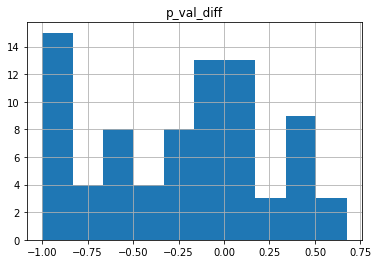


Log Rank


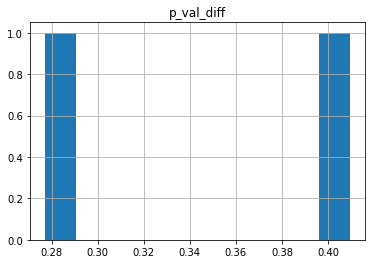


t-test, 2 sided


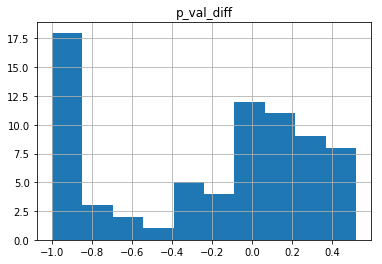


Mixed Models Analysis


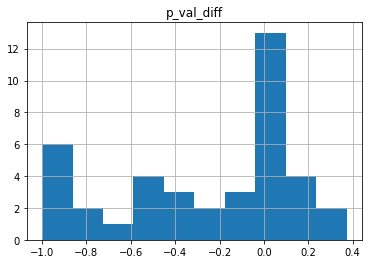


Fisher Exact


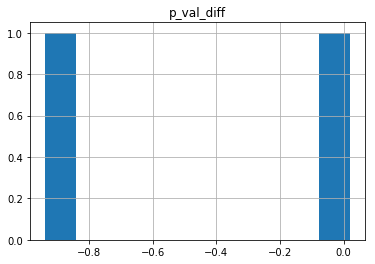


Wilcoxon (Mann-Whitney)


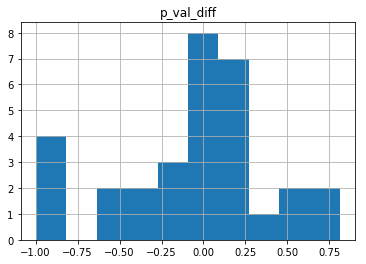


Chi-squared


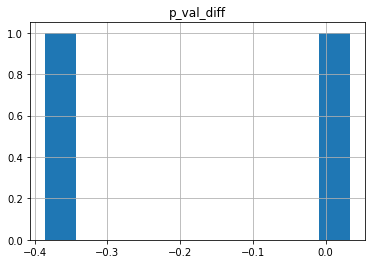


ANOVA


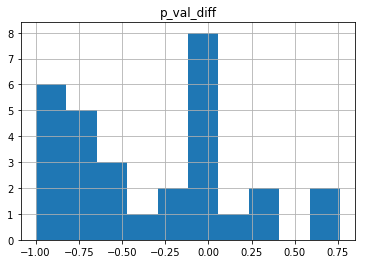


Cochran-Mantel-Haenszel


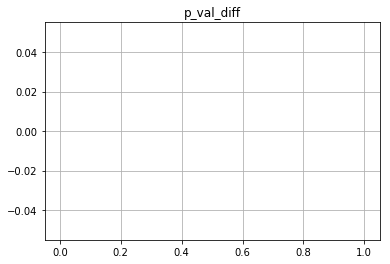


Regression, Logistic


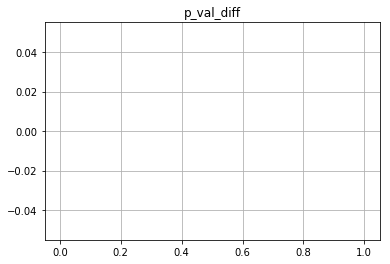

In [34]:
for method in top_methods:
    print(method)
    study_values[study_values.oa_method==method][['p_val_diff']].hist()
    plt.title=method
    plt.show()
    print('')

In [37]:
chi_square

5.908869986806964